In [1]:
from datetime import datetime
import pymongo
import pytz
import pandas as pd
from dateutil.parser import parse as dateParser
import datautil
import re
import numpy as np
import sys
import matplotlib.pyplot as plt
from typing import List, Set
import csv
import os
from tqdm.auto import tqdm   # progress bar keeps human being happy
import multiprocessing as mp

In [6]:
# cache
CACHE_DIR = "cache/"
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
# connect to mongodb
MONGO_URL = "mongodb://127.0.0.1:27017"
db = pymongo.MongoClient(MONGO_URL, connect=False).migration_helper
raw_db = pymongo.MongoClient(MONGO_URL).libraries
raw_db

Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'libraries')

In [3]:
# saving migration_changes.csv: too big for the repo
if not os.path.exists('cache/migration_changes.csv.csv'):
    import datautil
    import pandas as pd
    dep_change = datautil.select_dependency_changes_all()
    print(len(dep_change))

KeyboardInterrupt: 

In [26]:
dep_change[dep_change['lib2']=='ant:ant']

,Unnamed: 0,Unnamed: 0.1,project,commit,file,type,lib1,lib2,ver1,ver2,is_in_woc,time
38154,38154,38154,eugenp/tutorials,e85ec983d1c38dd41bfa566247671d9b5ea60e19,servlet-jsp-lihongjie/apache-tomcat-7.0.82-src...,add,?,ant:ant,?,1.7.0,True,2018-03-06 14:58:39+00:00
45081,45081,45081,SeleniumHQ/selenium,d195553b17713fa47551942d9601d5af990e175f,pom.xml,add,?,ant:ant,?,1.6.5,True,2007-03-24 17:33:17+00:00
45139,45139,45139,SeleniumHQ/selenium,0f1cc1f7e1e50383c83ff432f5918f27568b0a50,remote/server/pom.xml,add,?,ant:ant,?,1.6.5,True,2009-12-10 12:16:05+00:00
45201,45201,45201,SeleniumHQ/selenium,0973e11b4228a50c3a84bed37a7ff2aa7368d0cb,server-coreless/pom.xml,add,?,ant:ant,?,1.6.5,True,2006-11-03 18:51:08+00:00
45204,45204,45204,SeleniumHQ/selenium,d195553b17713fa47551942d9601d5af990e175f,server-coreless/pom.xml,verchg,ant:ant,ant:ant,1.6.5,?,True,2007-03-24 17:33:17+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3308454,3308454,3308454,myabc/appfuse,7773d03a7ae542b82ce03565d484532b2bf4fc90,web/common/pom.xml,verchg,ant:ant,ant:ant,1.6.5,${ant.version},True,2006-10-05 05:56:30+00:00
3308672,3308672,3308672,emmanuelbernard/hibernate-core-ogm,d8d6d82e30960e0c255950eaf875ad48831b12b0,code/core/pom.xml,add,?,ant:ant,?,1.6.5,True,2007-06-29 19:23:45+00:00
3308701,3308701,3308701,emmanuelbernard/hibernate-core-ogm,a797998927e2cbba9ec34ca7dc31b42a192fa2f1,core/pom.xml,add,?,ant:ant,?,1.6.5,True,2007-07-17 03:15:03+00:00
3308719,3308719,3308719,emmanuelbernard/hibernate-core-ogm,835ae2c0bfbbf6bdf2c4ea2d9d1b7619d02cb1c4,distribution/pom.xml,add,?,ant:ant,?,1.6.5,True,2010-04-07 22:46:58+00:00


In [27]:
# simple check here: all commits in woc?
# also add timestamp to df

# why using pool is slower,,, 

# def is_in_woc(df_split: pd.DataFrame) -> bool:
#     for index, row in df_split.iterrows():
#         c = db.wocCommit.find_one({"_id": row['commit']})
#         df_split.at[index, 'is_in_woc'] = True if c else False
#     return df_split
# n_workers=mp.cpu_count() // 2
# df_split=np.array_split(dep_change, n_workers)
# with mp.Pool(n_workers) as pool:
#     dep_change = pd.concat(pool.imap(is_in_woc, df_split))
# dep_change[dep_change['is_in_woc']==False]

# going with single thread anyway
if not os.path.exists('cache/migration_changes.csv.csv'):
    for (index, commit) in tqdm(list(enumerate(dep_change['commit']))):
        c = db.wocCommit.find_one({"_id": commit})
        dep_change.at[index, 'is_in_woc'] = True if c else False
        dep_change.at[index, 'time'] = c['timestamp'].replace(tzinfo=pytz.timezone('UTC'))

    dep_change.to_csv('cache/migration_changes.csv', index=False)
    dep_change

KeyboardInterrupt: 

In [2]:
# load df from disk if ssh fails
dep_change = pd.read_csv('cache/migration_changes.csv', low_memory=False)
dep_change

,Unnamed: 0,Unnamed: 0.1,project,commit,file,type,lib1,lib2,ver1,ver2,is_in_woc,time
0,0,0,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,NaN,commons-codec:commons-codec,NaN,1.8,True,2019-03-25 09:19:36+00:00
1,1,1,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,NaN,junit:junit,NaN,4.12,True,2019-03-25 09:19:36+00:00
2,2,2,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,NaN,org.bouncycastle:bcprov-jdk15on,NaN,1.56,True,2019-03-25 09:19:36+00:00
3,3,3,Snailclimb/JavaGuide,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,NaN,commons-codec:commons-codec,NaN,1.8,True,2018-07-31 06:49:01+00:00
4,4,4,Snailclimb/JavaGuide,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,NaN,junit:junit,NaN,3.8.1,True,2018-07-31 06:49:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3329244,3329244,3329244,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,commons-lang:commons-lang,NaN,NaN,True,2012-08-09 05:57:30+00:00
3329245,3329245,3329245,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,javassist:javassist,NaN,NaN,True,2012-08-09 05:57:30+00:00
3329246,3329246,3329246,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,javax.mail:mail,NaN,NaN,True,2012-08-09 05:57:30+00:00
3329247,3329247,3329247,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,mysql:mysql-connector-java,NaN,5.1.18,True,2012-08-09 05:57:30+00:00


In [3]:
dep_change[pd.to_datetime(dep_change['time']) > datetime(2018, 10, 13, 1, 5, 24).replace(tzinfo=pytz.timezone('UTC'))].sort_values(by='time')

,Unnamed: 0,Unnamed: 0.1,project,commit,file,type,lib1,lib2,ver1,ver2,is_in_woc,time
211394,211394,211394,aws/aws-sdk-java,f5261a7868898c8fbe7998e8a9b033aa85e05ce3,aws-java-sdk-opensdk/pom.xml,verchg,com.amazonaws:aws-java-sdk-core,com.amazonaws:aws-java-sdk-core,1.11.428-SNAPSHOT,1.11.428,True,2018-10-13 01:17:59+00:00
201977,201977,201977,aws/aws-sdk-java,f5261a7868898c8fbe7998e8a9b033aa85e05ce3,aws-java-sdk-bundle/pom.xml,verchg,com.amazonaws:aws-java-sdk,com.amazonaws:aws-java-sdk,1.11.428-SNAPSHOT,1.11.428,True,2018-10-13 01:17:59+00:00
211395,211395,211395,aws/aws-sdk-java,5e405c2a4b5d9f39ace995039d949586882ce226,aws-java-sdk-opensdk/pom.xml,verchg,com.amazonaws:aws-java-sdk-core,com.amazonaws:aws-java-sdk-core,1.11.428,1.11.429-SNAPSHOT,True,2018-10-13 01:19:33+00:00
201978,201978,201978,aws/aws-sdk-java,5e405c2a4b5d9f39ace995039d949586882ce226,aws-java-sdk-bundle/pom.xml,verchg,com.amazonaws:aws-java-sdk,com.amazonaws:aws-java-sdk,1.11.428,1.11.429-SNAPSHOT,True,2018-10-13 01:19:33+00:00
2452524,2452524,2452524,atlasmap/atlasmap,b7c64a031d3542334c4e84eb79d8b7a00e1c3279,parent/pom.xml,verchg,com.fasterxml.jackson.core:jackson-core,com.fasterxml.jackson.core:jackson-core,2.8.5,2.8.11,True,2018-10-13 02:50:43+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
290189,290189,290189,vert-x3/vertx-examples,b66c25b1ca0321989d8eb09a2e2eaf9d60aac97b,openshift3-examples/vertx-openshift-applicatio...,verchg,io.vertx:vertx-core,io.vertx:vertx-core,3.8.5,3.9.0,True,2020-03-28 12:50:21+00:00
290455,290455,290455,vert-x3/vertx-examples,b66c25b1ca0321989d8eb09a2e2eaf9d60aac97b,spring-examples/springboot-example/pom.xml,verchg,io.vertx:vertx-web,io.vertx:vertx-web,3.8.5,3.9.0,True,2020-03-28 12:50:21+00:00
290456,290456,290456,vert-x3/vertx-examples,b66c25b1ca0321989d8eb09a2e2eaf9d60aac97b,spring-examples/springboot-example/pom.xml,verchg,io.vertx:vertx-core,io.vertx:vertx-core,3.8.5,3.9.0,True,2020-03-28 12:50:21+00:00
290143,290143,290143,vert-x3/vertx-examples,b66c25b1ca0321989d8eb09a2e2eaf9d60aac97b,openshift3-examples/vertx-openshift-applicatio...,verchg,io.vertx:vertx-infinispan,io.vertx:vertx-infinispan,3.8.5,3.9.0,True,2020-03-28 12:50:21+00:00


In [4]:
# 5. 间接依赖里是否已经包含l
# 6. 其他依赖配置文件里是否已经声明了l
# for case 5 & 6, we only care about 'add'
 
dep_add = dep_change[dep_change['type']=='add']
dep_add

,Unnamed: 0,Unnamed: 0.1,project,commit,file,type,lib1,lib2,ver1,ver2,is_in_woc,time
0,0,0,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,NaN,commons-codec:commons-codec,NaN,1.8,True,2019-03-25 09:19:36+00:00
1,1,1,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,NaN,junit:junit,NaN,4.12,True,2019-03-25 09:19:36+00:00
2,2,2,Snailclimb/JavaGuide,e8aeaef43cbfb2b8a9b71c7b7f462c48b4adb9a6,docs/dataStructures-algorithms/source code/sec...,add,NaN,org.bouncycastle:bcprov-jdk15on,NaN,1.56,True,2019-03-25 09:19:36+00:00
3,3,3,Snailclimb/JavaGuide,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,NaN,commons-codec:commons-codec,NaN,1.8,True,2018-07-31 06:49:01+00:00
4,4,4,Snailclimb/JavaGuide,a17a2800c92f918842d26a9e9261ae0bba89286d,数据结构与算法/source code/securityAlgorithm/pom.xml,add,NaN,junit:junit,NaN,3.8.1,True,2018-07-31 06:49:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3329243,3329243,3329243,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,org.testng:testng,NaN,NaN,True,2012-08-09 05:57:30+00:00
3329244,3329244,3329244,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,commons-lang:commons-lang,NaN,NaN,True,2012-08-09 05:57:30+00:00
3329245,3329245,3329245,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,javassist:javassist,NaN,NaN,True,2012-08-09 05:57:30+00:00
3329246,3329246,3329246,88250/latke,3275e026145638664016be01437bd82649b688ff,pom.xml,add,NaN,javax.mail:mail,NaN,NaN,True,2012-08-09 05:57:30+00:00


In [7]:
# for better efficiency -> time in df
# return commit time in UTC
commits_not_found = set()

def get_commit_time(commit: str) -> datetime:
    c = db.wocCommit.find_one({"_id": commit})
    if c:
        return c['timestamp'].replace(tzinfo=pytz.timezone('UTC'))
    else:
        # should throw an exception here
        commits_not_found.insert(commit)
        return None

def get_dep_add_before(lib:str, before: datetime) -> pd.DataFrame:
    dep_add_lib = get_dep_add(lib)
    is_commit_before_migration = [get_commit_time(x) < before for x in dep_add_lib['commit']]
    return dep_add_lib[is_commit_before_migration]

get_commit_time('d195553b17713fa47551942d9601d5af990e175f')

datetime.datetime(2007, 3, 24, 17, 33, 17, tzinfo=<UTC>)

In [8]:
# get commits that added lib to dependencies
def get_dep_add(lib: str) -> pd.DataFrame:
    return dep_add[dep_add['lib2']==lib]


def get_dep_add_before(lib:str, before: datetime) -> pd.DataFrame:
    dep_add_lib = get_dep_add(lib)
    is_commit_before_migration = [dateParser(row['time']) < before for index, row in dep_add_lib.iterrows()]
    return dep_add_lib[is_commit_before_migration]

get_dep_add_before('org.apache.ant:ant', before=datetime.now().replace(tzinfo=pytz.timezone('UTC')))

,Unnamed: 0,Unnamed: 0.1,project,commit,file,type,lib1,lib2,ver1,ver2,is_in_woc,time
14963,14963,14963,spring-projects/spring-boot,c1ec5e5c0e9651f8404c3a085ff39731d748b706,spring-boot-parent/pom.xml,add,NaN,org.apache.ant:ant,NaN,1.7.0,True,2013-10-08 09:41:35+00:00
19554,19554,19554,spring-projects/spring-boot,da82f086927578b0938114ec360ab0fce9d1eb80,spring-boot-samples/spring-boot-sample-ant/pom...,add,NaN,org.apache.ant:ant,NaN,1.9.3,True,2015-06-30 07:30:33+00:00
24732,24732,24732,spring-projects/spring-boot,d255a7f0023a3a83ab7fc856346fe3c734fb0235,spring-boot-tools/spring-boot-antlib/pom.xml,add,NaN,org.apache.ant:ant,NaN,1.9.3,True,2015-06-26 23:23:27+00:00
24739,24739,24739,spring-projects/spring-boot,ae4559eb4f67a3cc1bc88b96b6b7abb747afe7fd,spring-boot-tools/spring-boot-antlib/pom.xml,add,NaN,org.apache.ant:ant,NaN,1.9.3,True,2015-06-30 07:30:28+00:00
45107,45107,45107,SeleniumHQ/selenium,b8835e66a9db18ffe803e326b42775f8dba9a0bb,pom.xml,add,NaN,org.apache.ant:ant,NaN,1.7.1,True,2009-05-14 18:33:45+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3319588,3319588,3319588,eclipse-efx/efxclipse-eclipse,4c3ea5e0634ac498a3a4e45315634e5b64d9fdd3,bundles/tooling/org.eclipse.fx.ide.ant/pom.xml,add,NaN,org.apache.ant:ant,NaN,1.8.4,True,2013-07-01 12:45:47+00:00
3322033,3322033,3322033,naver/hadoop,1f804b5d2031ddbae4f6ce17dbae3e950ecdde10,hadoop-common-project/hadoop-common/pom.xml,add,NaN,org.apache.ant:ant,NaN,NaN,True,2012-05-28 14:58:13+00:00
3322220,3322220,3322220,naver/hadoop,1f804b5d2031ddbae4f6ce17dbae3e950ecdde10,hadoop-hdfs-project/hadoop-hdfs/pom.xml,add,NaN,org.apache.ant:ant,NaN,NaN,True,2012-05-28 14:58:13+00:00
3322552,3322552,3322552,naver/hadoop,1f804b5d2031ddbae4f6ce17dbae3e950ecdde10,hadoop-project/pom.xml,add,NaN,org.apache.ant:ant,NaN,1.8.1,True,2012-05-28 14:58:13+00:00


In [9]:
# exceptions
class LioNotFoundException(Exception):
    pass
class WocNotFoundException(Exception):
    pass
class LibNotFoundException(Exception):
    pass

In [10]:
def parse_version(version: str) -> str:
    # ref: https://stackoverflow.com/questions/6618868
    if match := re.search('(\d+(?:\.\d+)+[-.]?[a-zA-Z\d]*)', version):
        return match.group(1)
    else:
        return ''

parse_version("[2.1.RC1,)"), parse_version("[1.3.2-alpha,)"), parse_version("$\{shuwarin.dreaming\}")

('2.1.RC1', '1.3.2-alpha', '')

In [11]:
# get corresponding version by searching raw_db (libraries.versions)
# deprecated: conflicts between raw_db & lio/woc

# wtf, why version[0]['Number'] is int

def get_first_version(lib: str) -> str:
    versions = list(raw_db.versions.find({"Platform": "Maven", "Project Name": lib}, sort=[("Published Timestamp", pymongo.ASCENDING)]))
    if not versions:
        raise LioNotFoundException(f'No version found for {lib}')
    return str(versions[0]['Number'])

def get_last_version(lib: str) -> str:
    versions = list(raw_db.versions.find({"Platform": "Maven", "Project Name": lib}, sort=[("Published Timestamp", pymongo.DESCENDING)]))
    if not versions:
        raise LioNotFoundException(f'No version found for {lib}')
    return str(versions[0]['Number'])

def get_last_version_before(lib: str, before: datetime) -> str:
    if not before:  # to make life easier
        return get_last_version(lib)
    versions = list(raw_db.versions.find({"Platform": "Maven", "Project Name": lib}, sort=[("Published Timestamp", pymongo.DESCENDING)]))
    for version in versions:
        if(dateParser(version['Published Timestamp']) < before):
            return str(version['Number'])
    raise LioNotFoundException(f'No version found for {lib} before {before}')
    return ''

# this function will NOT handle version mismatch; make sure it's valid
def get_version_published_time(lib: str, version: str) -> datetime:
    versions = list(raw_db.versions.find({"Platform": "Maven", "Project Name": lib, "Number": version}, sort=[("Published Timestamp", pymongo.DESCENDING)]))
    if not versions:
        raise LioNotFoundException(f'{lib} {version} not found')
    return dateParser(versions[0]['Published Timestamp'])

get_last_version_before('ant:ant', datetime.now().replace(tzinfo=pytz.timezone('UTC'))), get_version_published_time('ant:ant', '1.6.5')

('1.7.0', datetime.datetime(2005, 11, 22, 18, 6, 39, tzinfo=tzlocal()))

In [10]:
# get corresponding version by searching raw_db (libraries.versions)
# deprecated: conflicts between raw_db & lio/woc; slow

# parse version string to the most possible version lib actually use (text search)
# suprisingly slow,,,
def get_most_possible_version_lio_text(lib: str, version="", before=None) -> str:
    match = {"$match":{"Platform": "Maven", "Project Name": lib}}
    sort = {"$sort":{"Published Timestamp": -1}}

    if version: 
        # setup text index to use text query
        match = {"$match":{"Platform": "Maven", "Project Name": lib, "$text": {"$search":version}}}
        sort = {"$sort":{"score":{"$meta": "textScore"}, "Published Timestamp": -1}}

    aggregate_res = list(raw_db.versions.aggregate([match, sort], allowDiskUse=True))

    if not aggregate_res:
        raise LioNotFoundException(f'{lib} {version} not found in versions')
    # exact match
    if version == aggregate_res[0]['Number']:
        return aggregate_res[0]['Number']
    # if 'before' specified, return latest version before commit
    elif before is not None:
        res_before_commit = []
        for version in aggregate_res:
            if dateParser(version['Published Timestamp']) < before:
                res_before_commit.append(version['Number'])
        if not res_before_commit:
            raise LioNotFoundException(f'{lib} {version} before {before} not found in versions')
        return res_before_commit[0]
  
    return aggregate_res[0]['Number']

get_most_possible_version_lio_text('ant:ant', '[1.6.5]')

KeyboardInterrupt: 

In [ ]:
# deprecated: conflicts between raw_db & lio/woc; slow

# lookup direct dependencies in lioProjectDependency
# return format: [{lib:a:b, version: 1.0}]
def get_direct_dependencies_lio_text(lib: str, version="", commitTime=None) -> list:
    # no need to catch exception here: raw_db = lio
    version=get_most_possible_version_lio_text(lib, version)
    res = list(db.lioProjectDependency.find({"projectName": lib, "versionNumber": version}, sort=[("versionNumber", pymongo.DESCENDING)]))
    res_dep = []
    for dep in res:
        res_dep.append({'lib':dep['dependencyName'], 'version':dep['dependencyRequirements']})
    return res_dep

get_direct_dependencies_lio_text('ant:ant', '[1.6.5]')

In [13]:
# lookup direct dependencies in lioProjectDependency
# return format: { lib: 'lib', version: '1.1', dep: {'a': '1.0 } }

def get_direct_dependencies_lio(lib: str, version="", commitTime=None):
    res = []
    version_=None  # most possible candidiate in database
    group_id = lib.split(':')[0]
    artifact_id = lib.split(':')[-1]

    # skip 1-4 if version is empty
    if version:
        # 1. exact matching
        res = list(db.lioProjectDependency.find({"projectName": lib, "versionNumber": version},
            sort=[("versionNumber", pymongo.DESCENDING)]))
        # 2. version*
        if not res:
            version_=version
            res = list(db.lioProjectDependency.find({"projectName": lib, "versionNumber": {'$regex' :f"^{version_}"}},
                sort=[("versionNumber", pymongo.DESCENDING)]))
        # 3. remove dash
        if not res and '-' in version:
            version_=version.split('-')[0]
            res = list(db.lioProjectDependency.find({"projectName": lib, "versionNumber": {'$regex' :f"^{version_}"}},
                sort=[("versionNumber", pymongo.DESCENDING)]))
        # 4. remove last dot
        if not res:
            version_='.'.join(version.split('.')[:-1])
            # version_ may be an empty string?
            if version_:
                res = list(db.lioProjectDependency.find({"projectName": lib, "versionNumber": {'$regex' :f"^{version_}"}},
                    sort=[("versionNumber", pymongo.DESCENDING)]))
    
    # 5. find last version before commit
    # chances of conflicts btw maven & lio seems rare
    if not res and commitTime:
        version_ = get_last_version_before(lib=lib, before=commitTime)
        # print(version_)
        res = list(db.lioProjectDependency.find({"projectName": lib, "versionNumber": {'$regex' :f"^{version_}"}},
              sort=[("versionNumber", pymongo.DESCENDING)]))

    # sanity check here: published before commit (if we use regex to filter version)
    if version_ is not None and commitTime:
        res_filtered = []
        for item in res:
            try:
                published_time = get_version_published_time(lib, item['versionNumber'])
            except LioNotFoundException:  # not handling it
                continue
            if published_time < commitTime:
                res_filtered.append(item)
        res = res_filtered

    # 6. find all
    if not res:
        res = list(db.lioProjectDependency.find({"groupId": group_id, "artifactId": artifact_id},
            sort=[("versionNumber", pymongo.DESCENDING)]))
    if not res:
        
        raise LioNotFoundException(f'{lib} {version} not found after all attempts')

    final_version = res[0]["versionNumber"]
    res_dep = {}
    for dep in res:
        if dep['versionNumber'] == final_version:
           res_dep[dep['dependencyName']] = parse_version(dep['dependencyRequirements'])  # parse version and save
    return { 'lib':lib, 'version':final_version, 'dep':res_dep}

get_direct_dependencies_lio("org.hibernate:hibernate-core", '3.6.0', 
    datetime(2010, 11, 22, 18, 6, 39).replace(tzinfo=pytz.timezone('UTC')))

{'lib': 'org.hibernate:hibernate-core',
 'version': '3.6.0.Final',
 'dep': {'org.jboss.javaee:jboss-jacc-api_JDK4': '1.1.0',
  'javax.xml.bind:jaxb-api': '2.2',
  'ant:ant': '1.6.5',
  'com.sun.xml.bind:jaxb-impl': '2.1.12',
  'javax.transaction:jta': '1.1'}}

In [15]:
# lookup direct dependencies in libraryVersionToDependency
# return format: { lib: 'lib', version: '1.1', dep: {'a': '1.0 } }

def get_direct_dependencies_lib(lib: str, version="", commitTime=None):
    res = []
    version_=None  # most possible candidiate in database
    group_id = lib.split(':')[0]
    artifact_id = lib.split(':')[-1]

    # skip 1-4 if version is empty
    if version:
        # 1. exact matching
        res = list(db.libraryVersionToDependency.find({"groupId": group_id, "artifactId": artifact_id, "version": version},
            sort=[("version", pymongo.DESCENDING)]))
        # 2. version*
        if not res:
            version_=version
            res = list(db.libraryVersionToDependency.find({"groupId": group_id, "artifactId": artifact_id, 
                "version": {'$regex' :f"^{version_}"}},sort=[("version", pymongo.DESCENDING)]))
        # 3. remove dash
        if not res and '-' in version:
            version_=version.split('-')[0]
            res = list(db.libraryVersionToDependency.find({"groupId": group_id, "artifactId": artifact_id, 
                "version": {'$regex' :f"^{version_}"}},sort=[("version", pymongo.DESCENDING)]))
        # 4. remove last dot
        if not res:
            version_='.'.join(version.split('.')[:-1])
            # version_ may be an empty string?
            if version_:
                res = list(db.libraryVersionToDependency.find({"groupId": group_id, "artifactId": artifact_id, 
                    "version": {'$regex' :f"^{version_}"}},sort=[("version", pymongo.DESCENDING)]))
    
    # 5. find last version before commit
    # chances of conflicts btw maven & lio seems rare
    if not res and commitTime:
        version_ = get_last_version_before(lib=lib, before=commitTime)
        # print(version_)
        res = list(db.libraryVersionToDependency.find({"groupId": group_id, "artifactId": artifact_id, 
            "version": {'$regex' :f"^{version_}"}},sort=[("version", pymongo.DESCENDING)]))

    # sanity check here: published before commit (if we use regex to filter version)
    if version_ is not None and commitTime:
        res_filtered = []
        for item in res:
            try:
                published_time = get_version_published_time(lib, item['version'])
            except LioNotFoundException:  # not handling it
                continue
            if published_time < commitTime:
                res_filtered.append(item)
        res = res_filtered

    # 6. find all
    if not res:
        res = list(db.libraryVersionToDependency.find({"groupId": group_id, "artifactId": artifact_id},
            sort=[("version", pymongo.DESCENDING)]))
    if not res:
        raise LibNotFoundException(f'{lib} {version} not found after all attempts')

    # unify return format
    res_dep = {}
    for dep in res[0]['dependencies']:
        res_dep[dep['groupId']+':'+dep['artifactId']]=parse_version(dep['version'])  # parse version and save
    return { 'lib':lib, 'version':res[0]['version'], 'dep':res_dep}

get_direct_dependencies_lib("org.hibernate:hibernate-core", '3.6.0', 
    datetime(2010, 11, 22, 18, 6, 39).replace(tzinfo=pytz.timezone('UTC')))


{'lib': 'org.hibernate:hibernate-core',
 'version': '3.6.0.Final',
 'dep': {'dom4j:dom4j': '',
  'commons-collections:commons-collections': '',
  'javassist:javassist': '',
  'org.jboss.javaee:jboss-jacc-api_JDK4': '1.1.0',
  'org.hibernate.javax.persistence:hibernate-jpa-2.0-api': '',
  'javax.xml.bind:jaxb-api': '2.2',
  'antlr:antlr': '',
  'org.hibernate:hibernate-validator': '',
  'com.sun.xml.bind:jaxb-impl': '2.1.12',
  'cglib:cglib': '',
  'com.h2database:h2': '',
  'org.hibernate:hibernate-commons-annotations': '',
  'javax.validation:validation-api': '',
  'ant:ant': '1.6.5',
  'javax.transaction:jta': '1.1'}}

In [16]:
class DependencyVersionNotEqual(Exception):
    pass

# log on mismatch
dep_mismatch = []
dep_nonexist = []

# lookup in lib & lio, merge results
# return format: { lib: 'lib', version: '1.1', dep: {'a': '1.0 } }
def get_direct_dependencies(lib: str, version: str, commitTime=None):
    res_lio = res_lib = {}
    try:
        res_lio = get_direct_dependencies_lio(lib, version, commitTime)
        res_lib = get_direct_dependencies_lib(lib, version, commitTime)
    except (LioNotFoundException, LibNotFoundException) as e:
        # not exist in dataset,,,
        # print(e, file=sys.stderr)
        dep_nonexist.append({'lib': lib, 'version': version, 'commitTime': commitTime})
        return {'lib': lib, 'version': version, 'dep': {}}
    
    if res_lib == res_lio:
        return res_lib
    else:
        dep_mismatch.append({'lib': res_lib, 'lio': res_lio})
        # print({'lib': res_lib, 'lio': res_lio})
        
        # pick newer version if ver1!=ver2
        if res_lio['version'] != res_lib['version']:
            try:
                rel_lio = get_version_published_time(lib=lib, version=res_lio['version'])
                rel_lib = get_version_published_time(lib=lib, version=res_lib['version'])
                return res_lib if rel_lib > rel_lio else res_lio
            except (LioNotFoundException, LibNotFoundException):
                # compare version string if version not found in rawdb
                dep_nonexist.append({'lib': lib, 'version': version, 'commitTime': commitTime})
                return res_lib if res_lib['version'] > res_lio['version'] else res_lio

        # merge dependencies if ver1=ver2
        else:
            res_dep = res_lib['dep']
            for key, value in res_lio['dep'].items():
                if key in res_dep and res_dep[key] != value:  # lib & lio contain same dependency, diff version
                    # we can pick the non-empty one if 1 of 2 strs is empty
                    raise DependencyVersionNotEqual(f'{lib} {version} dep {key} lio: {value} / lib: {res_dep[key]}')
                    # ugly handling here,, but we're running out options
                    res_dep[key] = max(res_dep[key], value)
                else:
                    res_dep[key] = value
            return {'lib': lib, 'version': res_lio['version'], 'dep': res_dep}

get_direct_dependencies("org.hibernate:hibernate-core", '3.6.0', 
    datetime(2010, 11, 22, 18, 6, 39).replace(tzinfo=pytz.timezone('UTC')))

{'lib': 'org.hibernate:hibernate-core',
 'version': '3.6.0.Final',
 'dep': {'dom4j:dom4j': '',
  'commons-collections:commons-collections': '',
  'javassist:javassist': '',
  'org.jboss.javaee:jboss-jacc-api_JDK4': '1.1.0',
  'org.hibernate.javax.persistence:hibernate-jpa-2.0-api': '',
  'javax.xml.bind:jaxb-api': '2.2',
  'antlr:antlr': '',
  'org.hibernate:hibernate-validator': '',
  'com.sun.xml.bind:jaxb-impl': '2.1.12',
  'cglib:cglib': '',
  'com.h2database:h2': '',
  'org.hibernate:hibernate-commons-annotations': '',
  'javax.validation:validation-api': '',
  'ant:ant': '1.6.5',
  'javax.transaction:jta': '1.1'}}

In [19]:
# use leveldb to cache direct dependencies
import json
import plyvel

try:
    if cache_db.closed:
        cache_db = plyvel.DB('cache/migration', create_if_missing=True)
except NameError:
    cache_db = plyvel.DB('cache/migration', create_if_missing=True)

def cache_put(k: str, v: dict):
    key = k.encode('utf-8')
    value = json.dumps(v).encode('utf-8')
    cache_db.put(key, value)

def cache_get(k: str):
    key = k.encode('utf-8')
    res = cache_db.get(key)
    return json.loads(res) if res else None

def cache_delete(k: str):
    key = k.encode('utf-8')
    cache_db.delete(key)

cache_put('shuwarin', {'aya': 'kuro'}), cache_get('shuwarin'), cache_delete('shuwarin')

(None, {'aya': 'kuro'}, None)

In [20]:
# cache direct dependencies
from functools import wraps

total_lookup = 0
cache_hit = 0

def cache_direct_dep(f):
    @wraps(f)
    def wrapper(lib: str, version="", commitTime=None):
        global total_lookup, cache_hit
        total_lookup += 1
        if not version:
            try:
                version = get_last_version_before(lib=lib, before=commitTime)  # get last version before commit
            except LioNotFoundException:
                version = ""  
        # if no version found, cache doesn't make any sence
        cache = cache_get(lib+''+version) if version else None
        if cache:
            cache_hit += 1
            return cache
        else:
            res = f(lib, version, commitTime) 
            cache_put(lib+''+version, res)  # use argument rather than real version
            return res
    return wrapper

import time
def timethis(f):
    def wrapper(*args,**kwargs):
        start_time=time.perf_counter()
        res=f(*args,**kwargs)
        stop_time=time.perf_counter()
        print(f'{f.__name__} took {(stop_time - start_time)*1000} ms')
        return res
    return wrapper

In [21]:
# WARNING: if version not specified,
# get_direct_dependencies_cache would use lastest version in raw_db.versions rather than lio/lib

# @timethis
@cache_direct_dep
def get_direct_dependencies_cache(lib: str, version: str, commitTime=None):
    return get_direct_dependencies(lib, version, commitTime)

get_direct_dependencies_cache("org.hibernate:hibernate-core", '', datetime(2020, 11, 22, 18, 6, 39).replace(tzinfo=pytz.timezone('UTC')))
get_direct_dependencies_cache("junit:junit", '4.12')

{'lib': 'junit:junit',
 'version': '4.12',
 'dep': {'org.hamcrest:hamcrest-core': '1.3'}}

In [22]:
def thread_worker(df: pd.DataFrame):
    tqdm.pandas()
    dep_add['ver_lio'] = dep_add.progress_apply(lambda x: get_direct_dependencies_cache(x['lib'], x['version'], dateParser(x['time'])), axis=1)

from tqdm.contrib.concurrent import process_map  # basically a ProcessPoolExecutor
n_workers = 4
df_parts = np.array_split(dep_add ,n_workers)
dep_unique = pd.concat(process_map(thread_worker, df_parts, max_workers=n_workers))

dep_unique

NameError: name 'dep_unique' is not defined

In [23]:
# simple recursive lookup
# slow, 100ms with cache, 100s without cache (depth=4)
# @timethis
def get_all_dependencies(lib: str, version="", commitTime=None, depth=0):
    if depth == 0:
        return get_direct_dependencies_cache(lib, version, commitTime)
    direct_res = get_direct_dependencies_cache(lib, version, commitTime)
    direct_res['trans'] = []
    for key, value in direct_res['dep'].items():
        temp_res = get_all_dependencies(key, value, commitTime, depth-1)
        direct_res['trans'].append(temp_res)
    return direct_res

get_all_dependencies(lib="org.hibernate:hibernate-core", depth=4)

NameError: name 'get_direct_dependencies' is not defined

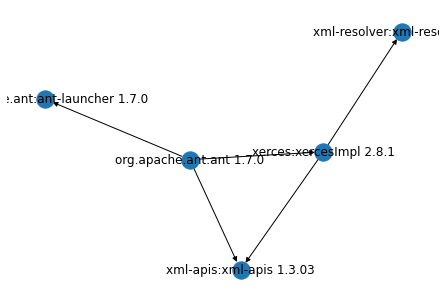

In [26]:
import networkx as nx 
dep_graph = nx.DiGraph()

# dependency graph should be acyclic
class LoopInDependencyGraph(Exception):
    pass 

def add_to_dependency_graph(lib: str, version="", commitTime=None, max_depth=100):
    if max_depth == 0:
        raise LoopInDependencyGraph(f'{lib} {version}')

    direct_res = get_direct_dependencies_cache(lib, version, commitTime)
    node_name = direct_res['lib'] + ' ' + direct_res['version']
    if not dep_graph.has_node(node_name):
        for key, value in direct_res['dep'].items():
            subnode_name = add_to_dependency_graph(key, value, commitTime, max_depth-1)
            dep_graph.add_edge(node_name, subnode_name)
    return node_name

import matplotlib.pyplot as plt 
add_to_dependency_graph('org.apache.ant:ant', '1.7.0', datetime(2020, 11, 22, 18, 6, 39).replace(tzinfo=pytz.timezone('UTC')))
nx.draw(dep_graph, with_labels=True)
plt.show()

In [17]:
# replace nan with '?'
dep_change = dep_change.fillna('?')
# dep_add.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
dep_name1 = pd.unique(dep_change['lib2'] + ':' + dep_change['ver2'])
dep_name2 = pd.unique(dep_change['lib1'] + ':' + dep_change['ver1'])
dep_name1, dep_name2

(array(['commons-codec:commons-codec:1.8', 'junit:junit:4.12',
        'org.bouncycastle:bcprov-jdk15on:1.56', ...,
        'org.b3log:latke-repository-h2:0.5.0-SNAPSHOT',
        'org.b3log:latke:${project.parent.version}',
        'com.yahoo.platform.yui:yuicompressor:\n'], dtype=object),
 array(['?:?', 'org.junit.jupiter:junit-jupiter-api:?', 'junit:junit:?',
        ..., 'org.b3log:latke:?',
        'org.b3log:latke:${project.parent.version}',
        'org.slf4j:slf4j-jdk14:1.7.30'], dtype=object))

In [18]:
dep_names = np.concatenate((dep_name1, dep_name2), axis=0)
dep_unique = pd.DataFrame(dep_names, columns=['dep_name'])
dep_unique

,dep_name
0,commons-codec:commons-codec:1.8
1,junit:junit:4.12
2,org.bouncycastle:bcprov-jdk15on:1.56
3,junit:junit:3.8.1
4,junit:junit:?
...,...
657421,io.swagger:swagger-annotations:${swagger.core....
657422,com.alibaba.rocketmq:rocketmq-client:3.5.9
657423,org.b3log:latke:?
657424,org.b3log:latke:${project.parent.version}


In [15]:
for index, row in tqdm(list(dep_unique.iterrows())):
    dep_unique.at[index, 'lib'] = ':'.join(str(row['dep_name']).split(':')[:-1])
    dep_unique.at[index, 'version'] = parse_version(str(row['dep_name']).split(':')[-1])
    try:
        dep_unique.at[index, 'published_time'] = get_version_published_time(dep_unique.at[index, 'lib'], dep_unique.at[index, 'version'])
    except LioNotFoundException:
        dep_unique.at[index, 'published_time'] = None
# checkpoint here
dep_unique.to_csv('cache/dep_unique.csv', index=False)
dep_unique

NameError: name 'dep_unique' is not defined

In [19]:
dep_unique=pd.read_csv('cache/dep_unique.csv', low_memory=False)
dep_unique

,dep_name,lib,version,published_time
0,commons-codec:commons-codec:1.8,commons-codec:commons-codec,1.8,NaN
1,junit:junit:4.12,junit:junit,4.12,NaN
2,org.bouncycastle:bcprov-jdk15on:1.56,org.bouncycastle:bcprov-jdk15on,1.56,NaN
3,junit:junit:3.8.1,junit:junit,3.8.1,2005-08-01 09:42:48+00:00
4,junit:junit:?,junit:junit,NaN,NaN
...,...,...,...,...
657421,io.swagger:swagger-annotations:${swagger.core....,io.swagger:swagger-annotations,NaN,NaN
657422,com.alibaba.rocketmq:rocketmq-client:3.5.9,com.alibaba.rocketmq:rocketmq-client,3.5.9,2016-09-15 07:16:54+00:00
657423,org.b3log:latke:?,org.b3log:latke,NaN,NaN
657424,org.b3log:latke:${project.parent.version},org.b3log:latke,NaN,NaN


In [ ]:
from tqdm.contrib.concurrent import thread_map
import pickle

# log on mismatch

dep_mismatch = []
dep_nonexist = []
dep_loop = []
dep_not_equal = []
total_lookup = 0
cache_hit = 0

dep_graph = nx.DiGraph()

def thread_worker(row):
    try:
        # data format loss in csv?
        lib = str(row['lib'])
        version = str(row['version'])
        published_time = pd.to_datetime(row['published_time']) if row['published_time'] else None
        add_to_dependency_graph(lib, version, published_time, 25)  # only handle 25 layers
    except (LioNotFoundException, LibNotFoundException) as e:
        print(e, file=sys.stderr)
        dep_nonexist.append({'lib':row['lib'], 'version':row['version'], "msg": e})
    except LoopInDependencyGraph as e:
        dep_loop.append({'lib':row['lib'], 'version':row['version'], "msg": e})
    except DependencyVersionNotEqual as e:
        dep_not_equal.append({'lib':row['lib'], 'version':row['version'], "msg": e})

n_workers = mp.cpu_count() // 2
args = [x[1] for x in dep_unique.iterrows()]
thread_map(thread_worker, args, max_workers=n_workers)  # didn't know you can do this

# checkpoint here
nx.write_gpickle(dep_graph, "cache/dep_graph.gz")
pickle.dump(dep_mismatch, "cache/mismatch.pkl")
pickle.dump(dep_nonexist, "cache/nonexist.pkl")
pickle.dump(dep_loop, "cache/loop.pkl")
pickle.dump(dep_not_equal,"cache/not_equal.pkl")
print(f"{dep_graph.number_of_nodes()} libs, {dep_graph.number_of_edges()} deps")
print(f"cache hits:{cache_hit}/{total_lookup}")
print(f"mismatch:{len(dep_mismatch)}, nonexist:{len(dep_nonexist)}, too_deep:{len(dep_loop)}, not_equal{len(dep_not_equal)}")

In [7]:
import networkx as nx
dep_graph = nx.read_gpickle("cache/dep_graph.gz")
dep_mismatch = pickle.load("cache/mismatch.pkl")
dep_nonexist = pickle.dump("cache/nonexist.pkl")
dep_loop = pickle.dump("cache/loop.pkl")
dep_not_equal = pickle.dump("cache/not_equal.pkl")
print(f"{dep_graph.number_of_nodes()} libs, {dep_graph.number_of_edges()} deps")
print(f"cache hits:{cache_hit}/{total_lookup}")
print(f"mismatch:{len(dep_mismatch)}, nonexist:{len(dep_nonexist)}, too_deep:{len(dep_loop)}, not_equal{len(dep_not_equal)}")

FileNotFoundError: [Errno 2] No such file or directory: 'cache/dep_graph.gz'